First, import Resnet50

In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input

Height = 108
Width = 192

#include_top = False removes the fully connected layer
filters = ResNet50(weights = 'imagenet', include_top=False, 
                   input_shape=(Height,Width,3))

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Then, create a data generator

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import os

folderName = 'transfer data 0.1'

trainDir = folderName + '/movie_train'
validDir = folderName + '/movie_valid'
testDir = folderName + '/movie_test'
BatchNum = 5

#Look through the data to get the number of classes
directors = os.listdir(trainDir)
numClasses = len(directors)

#preprocess_input is the ResNet50 specific preprocessing function
trainData_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True)

train_gen = trainData_gen.flow_from_directory(trainDir, target_size=(Height,Width),
                                              batch_size = BatchNum)

validData_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True)

valid_gen = validData_gen.flow_from_directory(validDir, target_size=(Height,Width),
                                              batch_size = BatchNum)

testData_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True)

test_gen = testData_gen.flow_from_directory(testDir, target_size=(Height,Width),
                                              batch_size = BatchNum)

Found 1889 images belonging to 6 classes.
Found 646 images belonging to 6 classes.
Found 338 images belonging to 6 classes.


Modify the imported model

In [3]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam

# Number of fully connected Neurons
numNeur = 200
# Dropout Rate
r = 0.5
# Learning Rate
lr = 0.0001
# Number of fully connected layers
numLay = 2

# Freeze the filter weights
for layer in filters.layers:
    layer.trainable = False

# Set up a fully connected layer
x = Flatten()(filters.output)
for i in range(numLay):
    x = Dense(numNeur, activation = 'relu')(x)
    x = Dropout(r)(x)
    
# Create a new softmax layer
out = Dense(numClasses, activation='softmax')(x)

fullModel = Model(inputs = filters.input, outputs = out)
fullModel.compile(optimizer=Adam(lr=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
fullModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 108, 192, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 114, 198, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 54, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 54, 96, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

Train the Model

In [4]:
import matplotlib.pyplot as plt
import numpy as np

epochs = 10

history = fullModel.fit_generator(train_gen,
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data = valid_gen)

#plt.plot(range(1,epochs+1), history.history['accuracy'])
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.show()

score = fullModel.evaluate_generator(test_gen)
print(score[1])


Epoch 1/10
378/378 [==============================] - 131s 347ms/step - loss: 2.0545 - accuracy: 0.2811 - val_loss: 2.2011 - val_accuracy: 0.3607
Epoch 2/10
378/378 [==============================] - 129s 342ms/step - loss: 1.5415 - accuracy: 0.3928 - val_loss: 0.9646 - val_accuracy: 0.4381
Epoch 3/10
378/378 [==============================] - 129s 341ms/step - loss: 1.4099 - accuracy: 0.4537 - val_loss: 1.0819 - val_accuracy: 0.4056
Epoch 4/10
378/378 [==============================] - 130s 344ms/step - loss: 1.3332 - accuracy: 0.5050 - val_loss: 1.2858 - val_accuracy: 0.3901
Epoch 5/10
378/378 [==============================] - 129s 341ms/step - loss: 1.2324 - accuracy: 0.5447 - val_loss: 0.0203 - val_accuracy: 0.4690
Epoch 6/10
378/378 [==============================] - 129s 342ms/step - loss: 1.0836 - accuracy: 0.6167 - val_loss: 17.8410 - val_accuracy: 0.3700
Epoch 7/10
378/378 [==============================] - 130s 343ms/step - loss: 0.9728 - accuracy: 0.6548 - val_loss: 6.9325

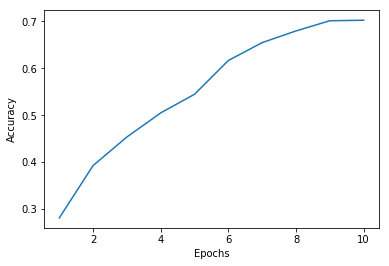

In [5]:
plt.plot(range(1,epochs+1), history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Test the Model

In [6]:
from sklearn.metrics import confusion_matrix

guess = fullModel.predict_generator(test_gen)
truth = test_gen.classes

matrix = confusion_matrix(truth,guess.argmax(axis=1))
print(matrix)

[[10 17  3  2  4 13]
 [13 18  7  0 11 10]
 [ 5 21 14  1 11 11]
 [ 5 19  8  3  7  9]
 [ 6 22 12  0 11 16]
 [ 4 16  8  3  3 15]]


Text(0.5, 15.0, 'Predicted Label')

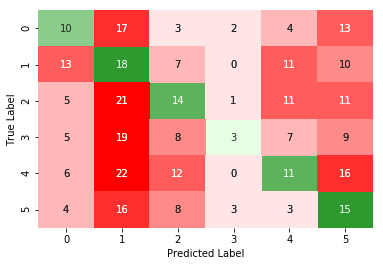

In [7]:
import seaborn as sn
import pandas as pd

# Plot the confusion matrix as a heatmap

sn.heatmap(matrix,cmap=sn.light_palette("green"),annot=True,cbar=False)
sn.heatmap(matrix,mask = np.eye(6),cmap=sn.light_palette("red"),annot=True,cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [8]:
np.eye(6)

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

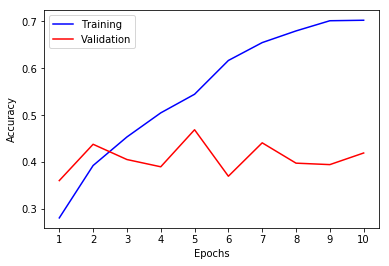

In [9]:
plt.plot(range(1,epochs+1), history.history['accuracy'],'b')
plt.plot(range(1,epochs+1),history.history['val_accuracy'],'r')
plt.xlabel('Epochs')
plt.xticks([i for i in range(1,epochs+1)])
plt.ylabel('Accuracy')
plt.legend(['Training','Validation'])
plt.savefig('transferAccVEpoch.png')

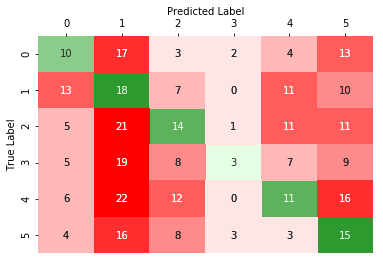

In [10]:
import seaborn as sn
import pandas as pd

# Plot the confusion matrix as a heatmap

sn.heatmap(matrix,cmap=sn.light_palette("green"),annot=True,cbar=False)
sn.heatmap(matrix,mask = np.eye(6),cmap=sn.light_palette("red"),annot=True,cbar=False)
plt.ylabel('True Label')
ax = plt.gca()
plt.xlabel('Predicted Label')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.savefig('transferConfuse.png')
